In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6101278115470852094
xla_global_id: -1
]


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r '/content/gdrive/Shareddrives/CS132: Data set/' '/content/'

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
df = pd.read_csv("CS132: Data set/Science Garden.csv")

# Data Cleaning

In [ ]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'RAINFALL', 'TMAX', 'TMIN', 'TMEAN', 'RH'], dtype='object')

## Let's convert the date columns to a single datetime column

In [ ]:
df["DATETIME"] = pd.to_datetime(df[["YEAR", "MONTH", "DAY"]])
df.drop(["YEAR", "MONTH", "DAY"], axis=1, inplace=True)

## Fill in missing values (-999)

In [ ]:
df_fill = df.replace(-999, np.NaN).fillna(df[df["RH"] != -999].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


# Data Exploration

## Initial Graphs of the data

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


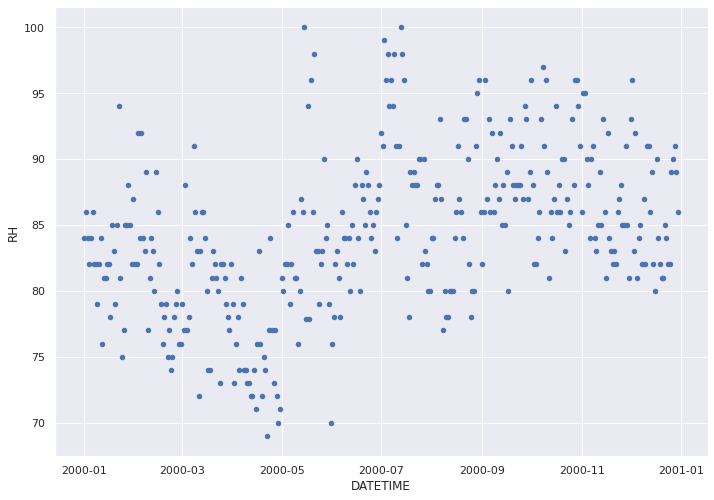

In [ ]:
df_fill[0:365].plot("DATETIME", "RH", "scatter")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


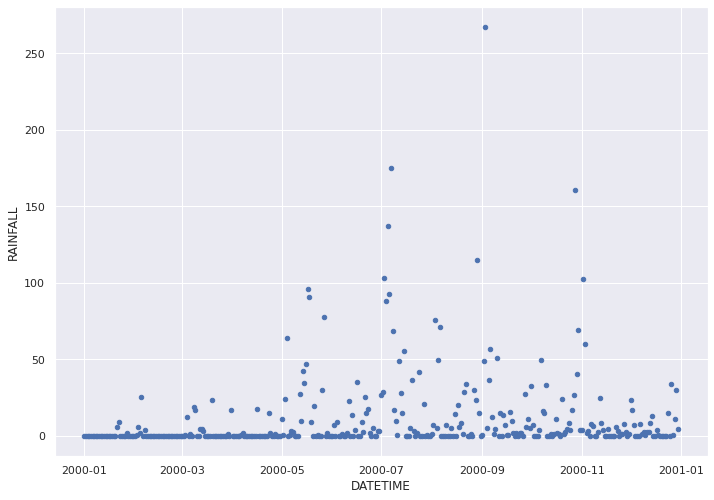

In [ ]:
df_fill[0:365].plot("DATETIME", "RAINFALL",  "scatter")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


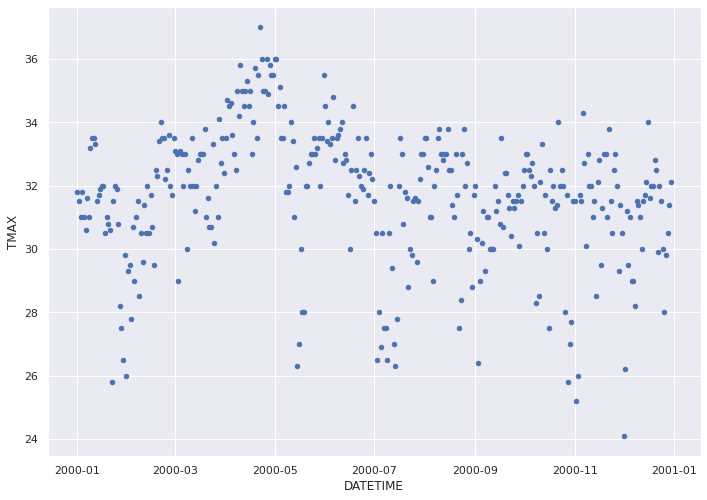

In [ ]:
df_fill[0:365].plot("DATETIME", "TMAX", "scatter")

## Feature extraction

We want to predict heavy rainfall but we want to have a way to classify what is 'heavy'. Fortunately, PAGASA has color codes which determines the responses to different RAINFALL levels. 

We can further simplify it by classifying yellow, orange and red as 'heavy' and the rest as 'light'. We assume that the daily rainfall happened within the span of 12 hours and that we want to divide the rainfall into 3 hour periods.


![picture](https://www.officialgazette.gov.ph/images/uploads/rainfall-english.jpg) Source: [https://www.officialgazette.gov.ph/how-to-make-sense-of-pagasas-color-coded-warning-signals/]

In [ ]:
df_extract = df_fill.copy()

We want to visualize the different rain level classifications first

In [ ]:
df_extract["COLOR"] = pd.cut(df_fill["RAINFALL"]*3/12, [-np.inf, 7.5, 15, 30, np.inf], right=False, labels=["Grey", "Yellow", "Orange", "Red"])

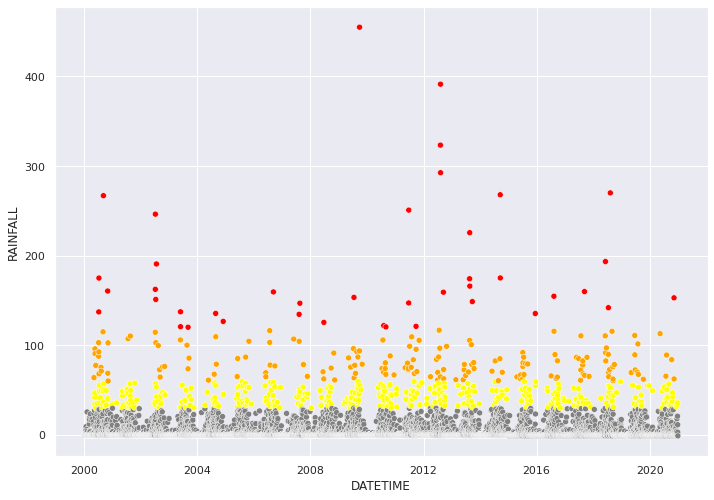

In [ ]:
sns.scatterplot(x=df_extract["DATETIME"], y=df_extract["RAINFALL"], c=df_extract["COLOR"])

From the table above, we then classify the data points to heavy and light

In [ ]:
df_extract["HEAVY"] = pd.cut(df_fill["RAINFALL"]*3/12, [-np.inf, 7.5, np.inf], right=False, labels=[0,1])

In [ ]:
_heavy_df = df_extract[df_extract["HEAVY"] == 1]
_light_df = df_extract[df_extract["HEAVY"] == 0]

### Heavy rainfall plots

Let's plot RELATIVE HUMIDITY with LIGHT AND HEAVY RAINFALL

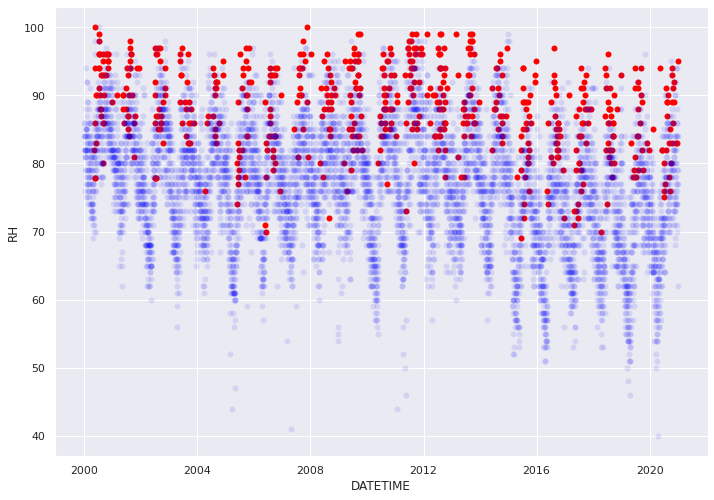

In [ ]:
ax = sns.scatterplot(x=_heavy_df["DATETIME"], y=_heavy_df["RH"], color="red", linewidth=0, alpha=1)
sns.scatterplot(x=_light_df["DATETIME"], y=_light_df["RH"], color="blue", linewidth=0, alpha=0.1, ax=ax)
ax

THEN TMAX and HEAVY/LIGHT RAINFALL


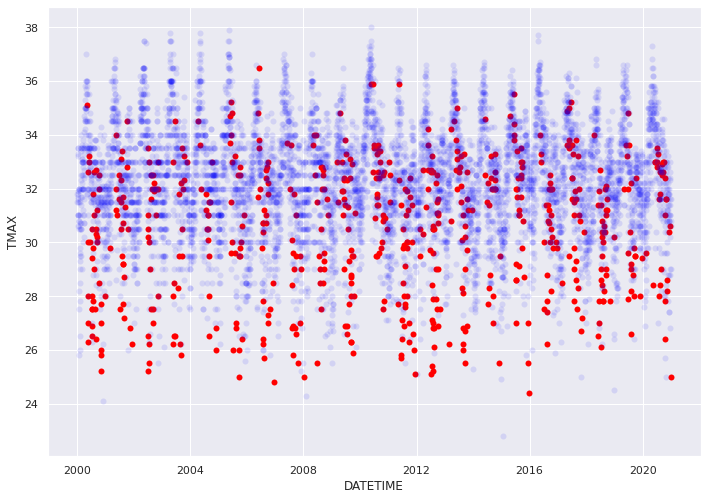

In [ ]:
ax = sns.scatterplot(x=_heavy_df["DATETIME"], y=_heavy_df["TMAX"], color="red", linewidth=0, alpha=1)
sns.scatterplot(x=_light_df["DATETIME"], y=_light_df["TMAX"], color="blue", linewidth=0, alpha=0.1, ax=ax)
ax

# Data Modeling

- How do we want to model the data?
1. Baseline: LinearRegression between RH & TMAX and RAINFALL in t_n
2. Improved Baseline: adding more terms

Of course this is not necessarily the solution to our problem. We are predicting the rainfall based on the data that we can already observe at that moment. What we want is to predict rainfall in the future.

3. Hacked up linear time series regression: Predict the future RAINFALL using previous data

4. Two stacked recurrent GRU unit network with dropout

This is inaccurate but it actually captured the behavior of our data even 7 days into the future. but using regression doesn't seem to work, but given our data earlier, instead of trying to predict the amount of rainfall for date, why not just predict whether or not the weather is heavy.



**Extreme rainfall prediction**

# Classification model

1. Just predicting 0 all the time 92.5%
2. Logistic regression (same day):
92.4% accuracy in the test set.
3. Improved baseline: 92.5%
4. Time series regression with weighted labels

In [ ]:
clim_data = df_extract.copy()

## Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
y = clim_data["RAINFALL"]
x = clim_data[["RH", "TMAX"]]

#train test validation
# (X_train,y_train) (X_val,y_val) (X_test,y_val)
X_train, X_val_test, y_train,y_val_test = train_test_split(x,y,test_size=0.3, shuffle=False)
X_val, X_test,y_val, y_test = train_test_split(X_val_test,y_val_test,test_size=0.5, shuffle=False)

mean = X_train.mean()
std = X_train.std()
X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std


### Baseline

In [ ]:
linearreg = LinearRegression()

In [ ]:
linearreg.fit(X_train, y_train)

LinearRegression()

In [ ]:
linearreg.score(X_val, y_val)

0.11595934527384477

### Baseline improved

In [ ]:
X_train_new = np.append(X_train, X_train**2, axis=1)
X_test_new = np.append(X_test, X_test**2, axis=1)

In [ ]:
linearreg_new = LinearRegression()

In [ ]:
linearreg_new.fit(X_train_new, y_train)

LinearRegression()

In [ ]:
linearreg_new.score(X_test_new, y_test)

0.192842568140987

### Time Series Linear Regression

In [ ]:
ts_y_train = y_train.shift(-1).fillna(0)
ts_y_test = y_test.shift(-1).fillna(0)

In [ ]:
ts_X_train = pd.concat([X_train, X_train.shift(1), X_train.shift(2), y_train, y_train.shift(1), y_train.shift(2)], axis=1).fillna(0)
ts_X_test = pd.concat([X_test, X_test.shift(1), X_test.shift(2), y_test, y_test.shift(1) ,y_test.shift(2)], axis=1).fillna(0)

In [ ]:
ts_linearreg = LinearRegression()

In [ ]:
ts_linearreg.fit(ts_X_train, ts_y_train)

LinearRegression()

In [ ]:
ts_linearreg.score(ts_X_test, ts_y_test)

0.03618176889526192

In [ ]:
test_dataframe = clim_data[y_train.shape[0] + y_val.shape[0]:].copy()

In [ ]:
preds = ts_linearreg.predict(ts_X_test)

In [ ]:
test_dataframe["preds"] = preds

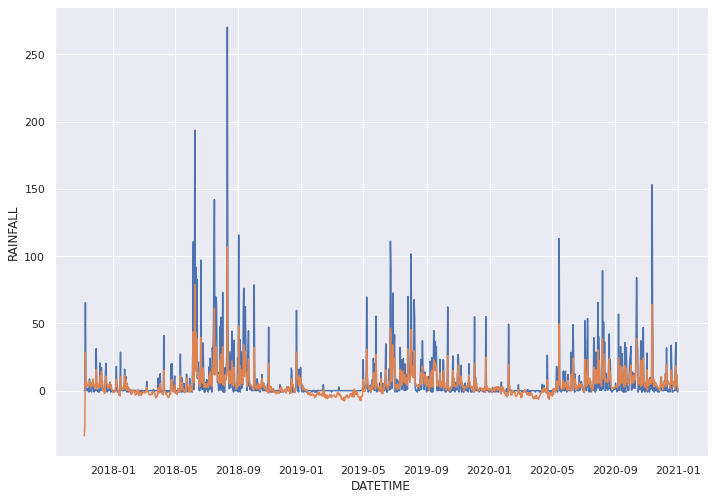

In [ ]:
ax = sns.lineplot(x=test_dataframe["DATETIME"], y=test_dataframe["RAINFALL"])
sns.lineplot(x=test_dataframe["DATETIME"], y=test_dataframe["preds"], ax=ax)

In [ ]:
preds = ts_linearreg.predict(ts_X_test) 
from sklearn.metrics import mean_squared_error
mean_squared_error(preds,ts_y_test)

362.8448871200203

Two stacked recurrent GRU unit network with dropout

num_train_samples 5753
num_val_samples 1534
num_test_samples 384


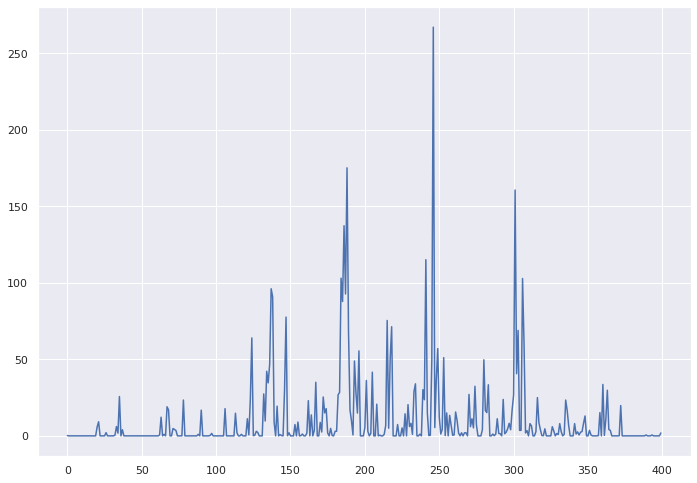

In [ ]:
#%%
import tensorflow.keras as keras, tensorflow as tf, numpy as np, pandas as pd
from tensorflow.keras import layers
from matplotlib import pyplot as plt
fname='CS132: Data set/Science Garden.csv'
def plot_losses(history):
    loss = history.history["mse"]
    val_loss = history.history["val_mse"]
    epochs = range(1,len(loss)+1)
    plt.figure()
    plt.plot(epochs,loss, "bo", label = "Training msE")
    plt.plot(epochs,val_loss, "b", label = "Validation msE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()
#%% Load data
df = pd.read_csv(fname) 
df.drop(["YEAR", "MONTH", "DAY"], axis=1, inplace=True)
#%% 
filtered_df = df.replace(-999, np.NaN).fillna(df[df["RH"] != -999].mean())
np_data = filtered_df.to_numpy(dtype=np.float64)
np_data[0]
#%% Plot data
rainfall = np.zeros((len(np_data),))
for i,line in enumerate(np_data):
    rainfall[i]=line[0].astype(np.float64)
# %% Plot narrow range
plt.plot(range(400),rainfall[:400])
# %%
num_train_samples = int(0.75 * len(np_data))
num_val_samples = int(0.2 * len(np_data))
num_test_samples = len(np_data)- num_train_samples - num_val_samples

print('num_train_samples',num_train_samples)
print('num_val_samples',num_val_samples)
print('num_test_samples',num_test_samples)


#### Create timeseries datasets
* sequence length = 36
* batch_size = 256
* sampling_rate = 1
* delay (step in future to predict) = 1

##### To do
- attention maybe
- concatenate other datasets, patterns in other datasets should contain necessary geo info

In [ ]:

mean = np_data[:num_train_samples].mean(axis=0)
np_data -= mean
std =  np_data[:num_train_samples].std(axis=0)
np_data /= std
# %%
sampling_rate = 1
sequence_length = 36
delay = 1
batch_size =256
train_dataset = keras.utils.timeseries_dataset_from_array(
    np_data[:-delay],
    targets = rainfall[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index=0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    np_data[:-delay],
    targets = rainfall[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples+num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    np_data[:-delay],
    targets = rainfall[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index = num_train_samples+num_val_samples
)

In [ ]:
# %%
for samples, targets in train_dataset:
    print("samples shape: {}".format(samples.shape))
    print("targets shape: {}".format(targets.shape))
    break
print(np_data[0])
# %% 
def evaluate_naive_method(dataset):
    total_abs_error = 0
    samples_seen = 0
    for samples, targets, in dataset:
        preds = samples[:,-1,0] * std[0]  +mean[0]
        total_abs_error += np.sum(np.abs(preds-targets))
        samples_seen += samples.shape[0]
    return total_abs_error/samples_seen 

print("Validation MAE: {}".format(evaluate_naive_method(val_dataset)))
print("Test MAE: {}".format(evaluate_naive_method(test_dataset)))
# %%
inputs = keras.Input(shape=(sequence_length,np_data.shape[-1]))
x = layers.GRU(32,recurrent_dropout=0.5,return_sequences=True)(inputs)
x = layers.GRU(32,recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)
model.compile(
    optimizer="rmsprop",loss="mse",metrics = ["mae"]
)


samples shape: (256, 36, 5)
targets shape: (256,)
[-0.35979359 -0.13594516 -0.52109761 -0.35145172  0.54407897]
Validation MAE: 11.900600400266844
Test MAE: 11.630747126436782


In [ ]:
history = model.fit(train_dataset,epochs = 2000, validation_data = val_dataset)
plot_losses(history)
# %%
preds = model.predict(test_dataset)
preds = preds.reshape(-1,)
tgets = rainfall[num_train_samples+num_val_samples+36:]

Epoch 1/2000
23/23 [==============================] - 8s 151ms/step - loss: 512.0338 - mae: 8.1567 - val_loss: 387.7482 - val_mae: 8.3933
Epoch 2/2000
23/23 [==============================] - 3s 128ms/step - loss: 464.8143 - mae: 8.9992 - val_loss: 366.8376 - val_mae: 9.1940
Epoch 3/2000
23/23 [==============================] - 3s 127ms/step - loss: 456.8094 - mae: 9.4728 - val_loss: 364.3561 - val_mae: 8.9076
Epoch 4/2000
23/23 [==============================] - 3s 130ms/step - loss: 453.5128 - mae: 9.2516 - val_loss: 359.9459 - val_mae: 8.9111
Epoch 5/2000
23/23 [==============================] - 3s 128ms/step - loss: 450.0077 - mae: 9.1127 - val_loss: 355.3382 - val_mae: 8.7433
Epoch 6/2000
23/23 [==============================] - 3s 131ms/step - loss: 445.7660 - mae: 8.9521 - val_loss: 352.4154 - val_mae: 8.9610
Epoch 7/2000
23/23 [==============================] - 3s 128ms/step - loss: 441.0002 - mae: 8.8533 - val_loss: 349.7628 - val_mae: 8.3535
Epoch 8/2000
23/23 [==============

KeyboardInterrupt: ignored

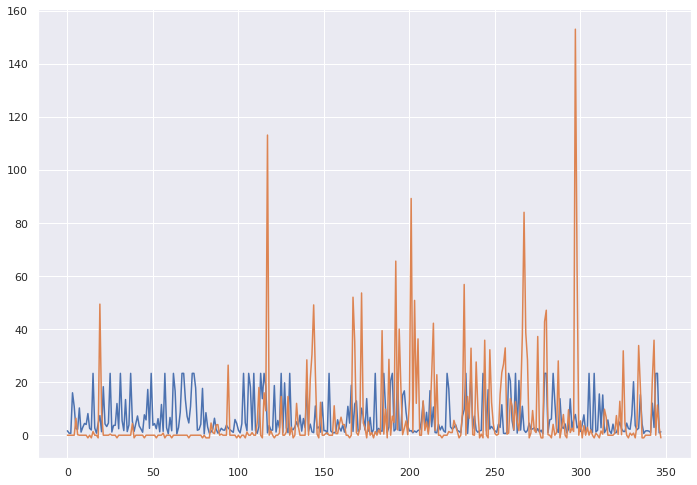

In [ ]:
import matplotlib.pyplot as plt
preds = model.predict(test_dataset)
preds = preds.reshape(-1,)
tgets = rainfall[num_train_samples+num_val_samples+36:]
plt.plot(preds)
plt.plot(tgets)

In [ ]:
mae = tf.keras.losses.MeanAbsoluteError()
mae(preds,tgets)

<tf.Tensor: shape=(), dtype=float64, numpy=10.475298881530762>

## Classification

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.model_selection import train_test_split

y = clim_data["HEAVY"]
x = clim_data[["RH", "TMAX"]]

#train test validation
# (X_train,y_train) (X_val,y_val) (X_test,y_val)
X_train, X_val_test, y_train,y_val_test = train_test_split(x,y,test_size=0.3, shuffle=False)
X_val, X_test,y_val, y_test = train_test_split(X_val_test,y_val_test,test_size=0.5, shuffle=False)

mean = X_train.mean()
std = X_train.std()
X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std

### Just predicting 0 all the time

In [ ]:
sum(y_test==0)/y_test.shape[0]

0.9252823631624674

### Logistic Regression (Same day)

In [ ]:
logic_reg = LogisticRegression()

In [ ]:
logic_reg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
logic_reg.score(X_test, y_test)

0.9244135534317984

## Logistic Regression (more terms)

In [ ]:
X_train_new = np.append(X_train, X_train**2, axis=1)
X_test_new = np.append(X_test, X_test**2, axis=1)

In [ ]:
logic_new = LogisticRegression()

In [ ]:
logic_new.fit(X_train_new, y_train)

LogisticRegression()

In [ ]:
logic_new.score(X_test_new, y_test)

0.9252823631624674

## Time series regression

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
w = {0:4, 1:96}

In [ ]:
ts_y_train = y_train.shift(-1).fillna(0)
ts_y_test = y_test.shift(-1).fillna(0)

In [ ]:
ts_X_train = pd.concat([X_train, X_train.shift(1), X_train.shift(2), y_train, y_train.shift(1), y_train.shift(2)], axis=1).fillna(0)
ts_X_test = pd.concat([X_test, X_test.shift(1), X_test.shift(2), y_test, y_test.shift(1) ,y_test.shift(2)], axis=1).fillna(0)

In [ ]:
ts_logic_new = LogisticRegression(max_iter=1000, class_weight=w)

In [ ]:
ts_logic_new.fit(ts_X_train, ts_y_train)

LogisticRegression(class_weight={0: 4, 1: 96}, max_iter=1000)

In [ ]:
confusion_matrix(ts_logic_new.predict(ts_X_train), ts_y_train)

array([[2307,   38],
       [2639,  385]])

In [ ]:
ts_logic_new.score(ts_X_test, ts_y_test)

0.7715030408340573

In [ ]:
confusion_matrix(ts_logic_new.predict(ts_X_test), ts_y_test)

array([[846,  44],
       [219,  42]])

## Two stacked recurrent GRU

Two stacked recurrent GRU unit network with dropout

In [ ]:
clim_data = df_extract.copy()

In [ ]:
#%%
import tensorflow.keras as keras, tensorflow as tf, numpy as np, pandas as pd
from tensorflow.keras import layers
from matplotlib import pyplot as plt
fname='CS132: Data set/Science Garden.csv'
def plot_losses(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1,len(loss)+1)
    plt.figure()
    plt.plot(epochs,loss, "bo", label = "Training loss")
    plt.plot(epochs,val_loss, "b", label = "Validation loss")
    plt.title("Training and validation Loss")
    plt.legend()
    plt.show()
#%% Load data
df = clim_data.copy() 
df.drop(["DATETIME", "COLOR"], axis=1, inplace=True)
#%% 
filtered_df = df.replace(-999, np.NaN).fillna(df[df["RH"] != -999].mean())
np_data = filtered_df.to_numpy(dtype=np.float64)
np_data[:,:-1]

features = np_data[:,:-1]
labels = tf.keras.utils.to_categorical(np_data[:,-1], num_classes=2)

num_train_samples = int(0.75 * len(np_data))
num_val_samples = int(0.2 * len(np_data))
num_test_samples = len(np_data)- num_train_samples - num_val_samples

print('num_train_samples',num_train_samples)
print('num_val_samples',num_val_samples)
print('num_test_samples',num_test_samples)


num_train_samples 5753
num_val_samples 1534
num_test_samples 384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


#### Create timeseries datasets
* sequence length = 36
* batch_size = 256
* sampling_rate = 1
* delay (step in future to predict) = 1

##### To do
- attention maybe
- concatenate other datasets, patterns in other datasets should contain necessary geo info

In [ ]:

mean = features[:num_train_samples].mean(axis=0)
features -= mean
std =  features[:num_train_samples].std(axis=0)
features /= std
# %%
sampling_rate = 1
sequence_length = 36
delay = 1
batch_size =256
train_dataset = keras.utils.timeseries_dataset_from_array(
    features[:-delay],
    targets = labels[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index=0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    features[:-delay],
    targets = labels[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples+num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    features[:-delay],
    targets = rainfall[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index = num_train_samples+num_val_samples
)

In [ ]:
# %%
for samples, targets in train_dataset:
    print("samples shape: {}".format(samples.shape))
    print("targets shape: {}".format(targets.shape))
    break
print(features[0])
# %% 
# def evaluate_naive_method(dataset):
#     total_abs_error = 0
#     samples_seen = 0
#     for samples, targets, in dataset:
#         preds = samples[:,-1,0] * std[0]  +mean[0]
#         total_abs_error += np.sum(np.abs(preds-targets))
#         samples_seen += samples.shape[0]
#     return total_abs_error/samples_seen 

# print("Validation MAE: {}".format(evaluate_naive_method(val_dataset)))
# print("Test MAE: {}".format(evaluate_naive_method(test_dataset)))
# %%
inputs = keras.Input(shape=(sequence_length,features.shape[-1]))
x = layers.GRU(32,recurrent_dropout=0.5,return_sequences=True)(inputs)
x = layers.GRU(32,recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)
model = keras.Model(inputs,outputs)
model.compile(
    optimizer="adam",loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics = [tf.keras.metrics.BinaryCrossentropy(), tf.keras.metrics.BinaryAccuracy()]
)


samples shape: (256, 36, 5)
targets shape: (256, 2)
[-0.35979359 -0.13594516 -0.52109761 -0.35145172  0.54407897]


Epoch 1/10
23/23 [==============================] - 3s 137ms/step - loss: 0.0020 - binary_crossentropy: 0.0020 - binary_accuracy: 0.9991 - val_loss: 0.0062 - val_binary_crossentropy: 0.0062 - val_binary_accuracy: 0.9987
Epoch 2/10
23/23 [==============================] - 3s 130ms/step - loss: 6.7471e-04 - binary_crossentropy: 6.7471e-04 - binary_accuracy: 0.9998 - val_loss: 0.0124 - val_binary_crossentropy: 0.0124 - val_binary_accuracy: 0.9967
Epoch 3/10
23/23 [==============================] - 3s 135ms/step - loss: 0.0011 - binary_crossentropy: 0.0011 - binary_accuracy: 0.9995 - val_loss: 0.0220 - val_binary_crossentropy: 0.0220 - val_binary_accuracy: 0.9947
Epoch 4/10
23/23 [==============================] - 3s 131ms/step - loss: 0.0022 - binary_crossentropy: 0.0022 - binary_accuracy: 0.9990 - val_loss: 0.0020 - val_binary_crossentropy: 0.0020 - val_binary_accuracy: 0.9993
Epoch 5/10
23/23 [==============================] - 3s 132ms/step - loss: 0.0036 - binary_crossentropy: 0.0036 -

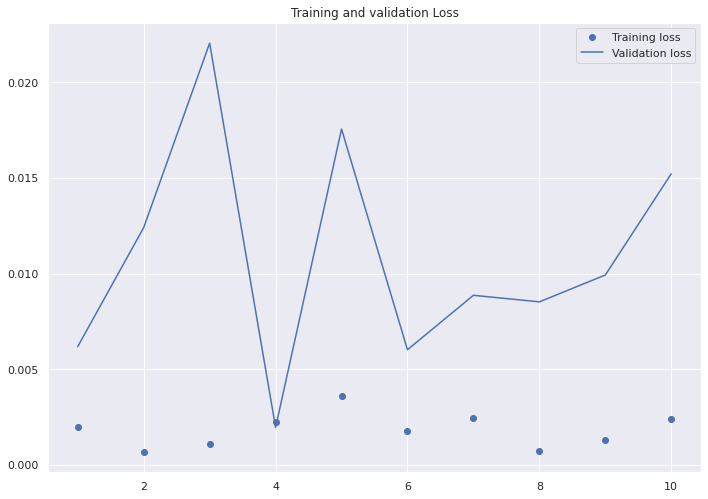

<tf.Tensor: shape=(), dtype=float32, numpy=0.8534483>

In [ ]:
history = model.fit(train_dataset,epochs = 10, validation_data = val_dataset)
plot_losses(history)
# %%
preds = model.predict(test_dataset)
preds = np.argmax(preds,axis=1)
tgets = labels[num_train_samples+num_val_samples+36:]
tgets = np.argmax(tgets,axis=1)
acc = tf.keras.metrics.BinaryAccuracy()
acc(preds,tgets)

In [ ]:
preds = model.predict(test_dataset)
preds = np.argmax(preds,axis=1)
tgets = labels[num_train_samples+num_val_samples+36:]
tgets = np.argmax(tgets,axis=1)
acc = tf.keras.metrics.BinaryAccuracy()
acc(preds,tgets)
# after 100 epochs, 84% accuracy

<tf.Tensor: shape=(), dtype=float32, numpy=0.8534483>